# Yolo V8 + SAM

We will see how to identify an object from an image using `Yolo`, then segmant that object using `SAM` and finally removing the background.

#### Install the required dependencies

In [2]:
!pip install wget 

  Using cached wget-3.2.zip (10 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=f30f703acb025ba9f60b22f048f9ee2244654405f974dba9cb191bfee4b0fed7
  Stored in directory: c:\users\krish\appdata\local\pip\cache\wheels\40\b3\0f\a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [1]:
# !pip install ultralytics

# %pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !python -m wget 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth' -O sam_vit_h_4b8939.pth
!python -m wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth sam_vit_h_4b8939.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

#### Import the things we need

In [1]:
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics YOLOv8.2.81  Python-3.11.9 torch-2.3.0+cpu CPU (12th Gen Intel Core(TM) i7-1255U)
Setup complete  (12 CPUs, 15.7 GB RAM, 72.2/293.0 GB disk)


#### Detect object using Yolo V8n

#### See the image

In [3]:
!yolo predict model=yolov8n.pt source='input.jpg'

Ultralytics YOLOv8.2.81 🚀 Python-3.11.9 torch-2.3.0+cpu CPU (12th Gen Intel Core(TM) i7-1255U)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 d:\Machine_Learning\extract-objects\input.jpg: 448x640 1 cat, 1 bear, 235.1ms
Speed: 11.4ms preprocess, 235.1ms inference, 16.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


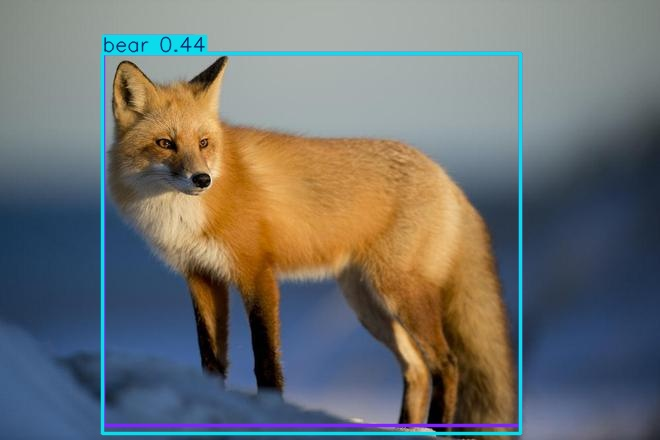

In [4]:
Image(filename='runs/detect/predict/input.jpg', height=600)

In [5]:
model = YOLO('yolov8n.pt')
results = model.predict(source='input.jpg', conf=0.25)


image 1/1 d:\Machine_Learning\extract-objects\input.jpg: 448x640 1 cat, 1 bear, 499.2ms
Speed: 2.0ms preprocess, 499.2ms inference, 10.6ms postprocess per image at shape (1, 3, 448, 640)


In [6]:
categories = results[0].names

In [7]:
categories[0]

'person'

In [8]:
dc = []
for i in range(len(results[0])):
    cat = results[0].boxes[i].cls
    dc.append(categories[int(cat)])

dc

# results[0].boxes[1].cls
# len(results[0])

['bear', 'cat']

In [18]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

bbox

[102.31700134277344, 53.55069351196289, 520.01904296875, 433.8064270019531]

In [19]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [20]:
image = cv2.cvtColor(cv2.imread('input.jpg'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [21]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

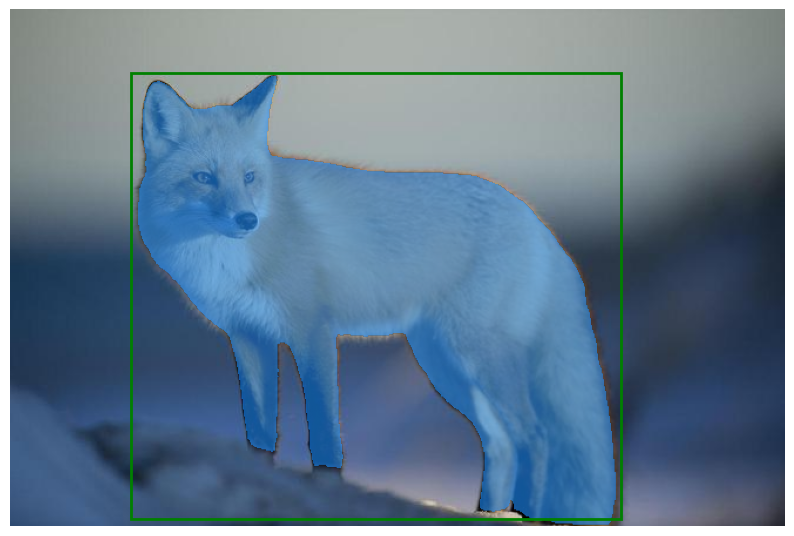

In [22]:
input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

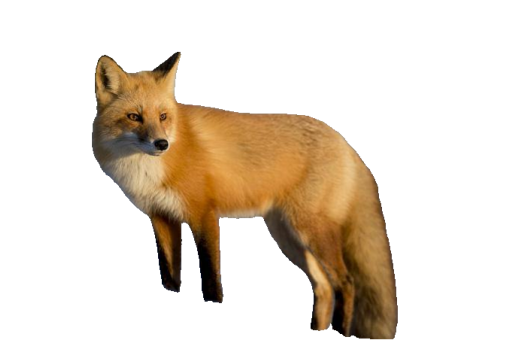

In [23]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


image 1/1 /content/input.jpg: 448x640 1 cat, 1 bear, 38.6ms
Speed: 4.3ms preprocess, 38.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


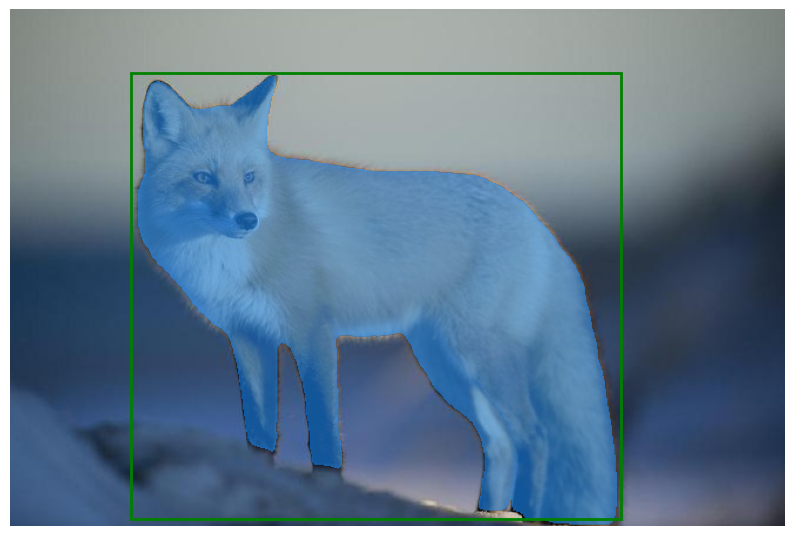

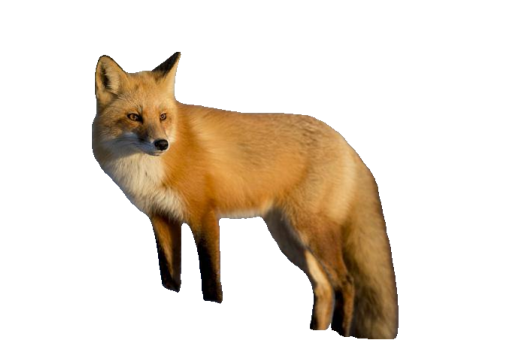

In [14]:
image_path = 'input.jpg'

results = model.predict(source=image_path, conf=0.25)

# The categories that can be predicted
categories = results[0].names

# Detected categories in the photo
dc = []
for i in range(len(results[0])):
    cat = results[0].boxes[i].cls
    dc.append(categories[int(cat)])



for result in results:
    boxes = result.boxes

# bbox=boxes.xyxy.tolist()[index_of_the_choosen_detected_object]

bbox=boxes.xyxy.tolist()[0]

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

predictor.set_image(image)

input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

In [34]:
print_image = new_image.astype(np.uint8)
# plt.axis('off')
# plt.savefig('finlllllll.jpg')
plt.imsave('finlllllllll.jpg', print_image)

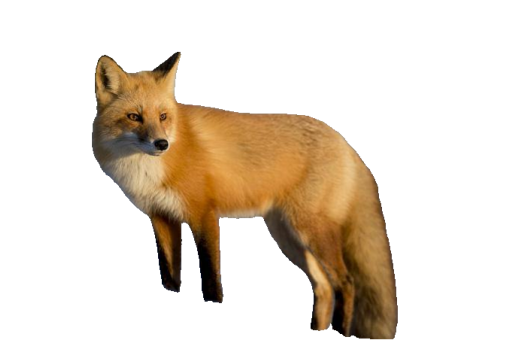

In [33]:
plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.savefig("extracted.jpg")
# plt.show()
# plt.imsave('')

In [22]:
# added to req.txt
# !pip install rembg

In [16]:
# Importing Required Modules
from rembg import remove
from PIL import Image




100%|###############################################| 176M/176M [00:00<?, ?B/s]


In [25]:
# Store path of the image in the variable input_path
input_path = 'extracted.jpg'

# Store path of the output image in the variable output_path
output_path = 'finalExtracted.png'

# Processing the image
input = Image.open(input_path)

# Removing the background from the given Image
output = remove(input)

#Saving the image in the given path
output.save(output_path)

In [29]:
a = ('hello', 'world')


In [32]:
a.index('world')

1